In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format

### 가격 변동성이 크고 거래량이 몰린 종목이 주가가 상승한다.    
"가격 변동성이 크고 거래량이 몰린 종목이 주가가 상승한다" 라는 가설을 증명하기 위해서는 "가격 변동성이 크다", "거래량이 몰린다" 등을 표현하는 변수가 필요합니다. 먼저 일봉데이터를 불러옵니다.

In [2]:
mdl_data = pd.read_pickle('mdl_data.pkl')
mdl_data.head().style.set_table_attributes('style="font-size: 10px"')

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,max_close
2021-01-05,2270,2285,2200,2250,410263,-0.004425,060310,3S,1.008326,0.995575,0,1.017778,1.017778,0.997778,0.966667,0.971111,1.017778
2021-01-06,2225,2310,2215,2290,570349,0.017778,060310,3S,0.995567,1.017778,1,1.000000,0.980349,0.949782,0.954148,0.949782,1.000000
2021-01-07,2290,2340,2240,2290,519777,0.000000,060310,3S,1.007612,1.000000,0,0.980349,0.949782,0.954148,0.949782,0.958515,0.980349
2021-01-08,2300,2315,2225,2245,462568,-0.019651,060310,3S,0.998918,0.980349,0,0.968820,0.973274,0.968820,0.977728,0.973274,0.977728
2021-01-11,2230,2275,2130,2175,409057,-0.031180,060310,3S,0.988702,0.968820,0,1.004598,1.000000,1.009195,1.004598,1.002299,1.009195


첫 번째 종목 060310 에 대하여 가격 변동성 변수를 만들어 보겠습니다. 전 5일 종가의 평균(price_mean), 전 5일 종가의 표준편차(price_std)를 먼저 구합니다. 그리고, 전 5일의 평균 및 표준편차 대비 당일 종가의 수준을 표준화해서 보여주는 값이 'price_z' 입니다. price_z 값이 -1.96 와 +1.96 안에 값이면 95% 신뢰구간 안에 들어갑니다. 즉 -1.96 보다 작거나, 1.96 보다 크면(100 번중 5번 미만으로 일어날 확율) 당일의 종가는 직전 5일의 움직임에 비해 아주 특별하다고 생각할 수 있습니다.

In [3]:
df = mdl_data[mdl_data['code']=='060310'].copy() 
df['price_mean'] = df['close'].rolling(5).mean() # 직전 5일 종가의 평균
df['price_std'] = df['close'].rolling(5).std() # 직전 5일 종가의 표준편차
df['price_z'] = (df['close'] - df['price_mean'])/df['price_std'] # 직전 5일 종가의 평균 및 표준편차 대비 오늘 종가의 위치
df[['close','price_mean','price_std','price_z']].head(10)

,close,price_mean,price_std,price_z
2021-01-05,2250,NaN,NaN,NaN
2021-01-06,2290,NaN,NaN,NaN
2021-01-07,2290,NaN,NaN,NaN
2021-01-08,2245,NaN,NaN,NaN
2021-01-11,2175,"2,250.000",47.037,-1.594
2021-01-12,2185,"2,237.000",55.295,-0.940
2021-01-13,2175,"2,214.000",51.527,-0.757
2021-01-14,2195,"2,195.000",29.155,0.000
2021-01-15,2185,"2,183.000",8.367,0.239
2021-01-18,2180,"2,184.000",7.416,-0.539


<br> 전 종목에 대하여 동일한 계산을 합니다. 그리고 그 결과를 data_h1 에 담습니다.

In [9]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_h1 = pd.DataFrame()

for code in kosdaq_list['code']:

    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    data['price_mean'] = data['close'].rolling(20).mean()
    data['price_std'] = data['close'].rolling(20).std(ddof=0)
    data['price_z'] = (data['close'] - data['price_mean'])/data['price_std']    
    
    data['volume_mean'] = data['volume'].rolling(20).mean()
    data['volume_std'] = data['volume'].rolling(20).std(ddof=0)
    data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std']
       
    data['max_close']  = data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 5 영업일 종가 수익율 중 최고 값
    data.dropna(subset=['price_z','volume_z','close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # missing 이 있는 행은 제거  
    
    data = data[(data['price_std']!=0) & (data['volume_std']!=0)] # 0 으로 나누는 상황은 없도록 함.
    
    data_h1 = pd.concat([data, data_h1], axis=0)

data_h1.to_pickle('data_h1.pkl')  

In [10]:
data_h1 = pd.read_pickle('data_h1.pkl')  
print(data_h1['price_z'].agg(['min','max']))
print(data_h1['volume_z'].agg(['min','max']))

min   -4.359
max    4.359
Name: price_z, dtype: float64
min   -2.568
max    4.359
Name: volume_z, dtype: float64


<AxesSubplot:xlabel='price_z'>

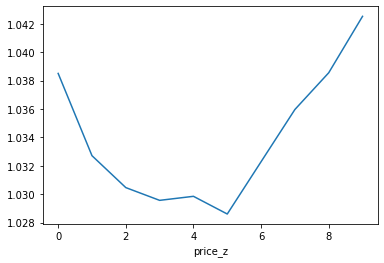

In [11]:
rank = pd.qcut(data_h1['price_z'], q=10, labels=range(10))
data_h1.groupby(rank)['max_close'].mean().plot()

<AxesSubplot:xlabel='volume_z'>

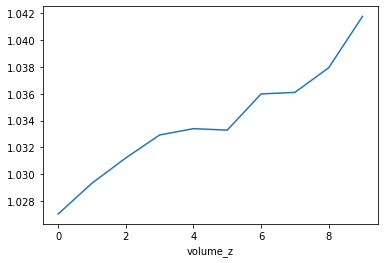

In [12]:
rank = pd.qcut(data_h1['volume_z'], q=10, labels=range(10))
data_h1.groupby(rank)['max_close'].mean().plot()

<br> 종가의 표준화 값 price_z 와 거래량의 표준화 값 volume_z 를 서로 직교하는 테이블로 구성하고 평균 수익율을 보니, 가격이 변동성이 높고, 거래량이 몰리는 종목은 평균 수익율이 더 높다는 것이 확인되었습니다.

In [13]:
rank1  = pd.qcut(data_h1['price_z'], q=5, labels=range(5))
rank2  = pd.qcut(data_h1['volume_z'], q=5, labels=range(5))

data_h1.groupby([rank1, rank2])['max_close'].mean().unstack()

volume_z,0,1,2,3,4
price_z,,,,,
0,1.032,1.034,1.035,1.038,1.040
1,1.028,1.029,1.031,1.033,1.035
2,1.026,1.030,1.030,1.031,1.032
3,1.028,1.035,1.035,1.036,1.037
4,1.029,1.038,1.038,1.039,1.044
